In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 모델 예측 결과물을 분석하여 모델 내부의 판단에 대한 분석을 했다.

- 대부분의 코드는 EDA_FINAL(+EDA_ARP)와 유사하다.
- 다만 input file이 평가자료인 CatBoost의 결과물인 AFSNT_DLY_CatBoost.csv이기때문에 다르다
- 따라서 자세한 설명은 EDA_FINAL에 있기 때문에 생략한다.

#전처리 및 변수 생성

In [0]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta

In [0]:
AFSNT = pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT_DLY_CatBoost.csv', engine = "python")

In [0]:
# Date 열 만들기
AFSNT=AFSNT.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT['Date']=pd.to_datetime(AFSNT.loc[:, ['Year','Month','Day']])

#당일 항공평수 피쳐 만들기
afsnt_count=AFSNT.groupby(['Date','ARP']).size().to_frame()
afsnt=pd.merge(AFSNT,afsnt_count,on=['Date','ARP'])
AFSNT = afsnt.rename(columns={0:'flights'})

# Slot 배정 구하기

def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute

AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)
arp_sort=AFSNT.sort_values(by=['Date','ARP','STT_minute'])
sttlen=(max(arp_sort['STT_minute'])-min(arp_sort['STT_minute']))/20
#print(sttlen)

def TTto60(TT):
    return int(TT/sttlen)

arp_sort['STT_category']=arp_sort['STT_minute'].apply(TTto60)


timetable=pd.DataFrame()
timetable=arp_sort.groupby(['Date','ARP','STT_category']).size()

windowsize=5
timetable=timetable.to_frame()
AFSNT=pd.merge(left=arp_sort,right=timetable,on=['Date','ARP','STT_category'])
AFSNT = AFSNT.rename(columns={0:'slots'})


In [0]:
def gethour(STT):
  hour,minute=STT.split(':')
  hour=int(hour)
  return hour

AFSNT['Hour']=AFSNT['STT'].apply(gethour)

In [0]:
#AFSNT.head(5)

In [0]:
STT_hour=AFSNT['STT'].str.split(':').str.get(0).astype('float64')

def weekdayn(Date):
  return Date.weekday()

# 시각 열 생성
def gethour(STT):
  hour,minute=STT.split(':')
  return hour
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute
def mysum(a,b):
  return a+b

AFSNT['Weekday']=AFSNT['Date'].apply(weekdayn)
AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)

##항공사(FLO) - 지연비율

In [0]:
# x와 y의 비율 plot
def stack_plot(x,y,df): 
    forstack=df.groupby([x,y]).size().unstack()
    forstack=forstack.transpose()
    if y=="DLY":
        forstack = forstack.div(forstack.sum()).transpose()
    else:
        forstack = forstack.div(forstack.sum()).transpose()
    forstack.plot(kind='bar',stacked=True,color=['steelblue','lightgrey'])

J    4464
A    2892
B    2234
H    1954
I    1680
F    1388
L    1368
M      96
Name: FLO, dtype: int64


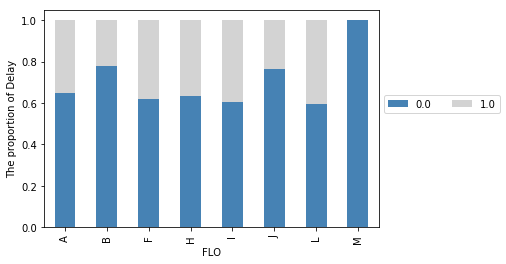

In [11]:
# 항공사별 지연 비율
stack_plot('FLO','DLY',AFSNT)
plt.legend(loc='lower left',ncol=5, bbox_to_anchor=(1, 0.5))
plt.ylabel('The proportion of Delay')
print(AFSNT['FLO'].value_counts())
plt.grid(False)

##항공사별 AOD(A/D)에 따른 지연비율

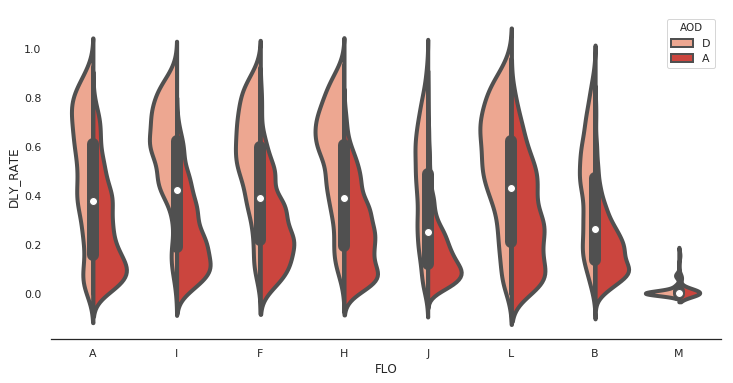

In [60]:
# AOD 따라 나눈 것
sns.set_style("white")
sns.violinplot(x='FLO',y='DLY_RATE',hue='AOD',data = AFSNT,split=True,palette='Reds')
sns.despine(left=True)
plt.show()

##출도착 공항에 따른 지연확률 히트맵그래프

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


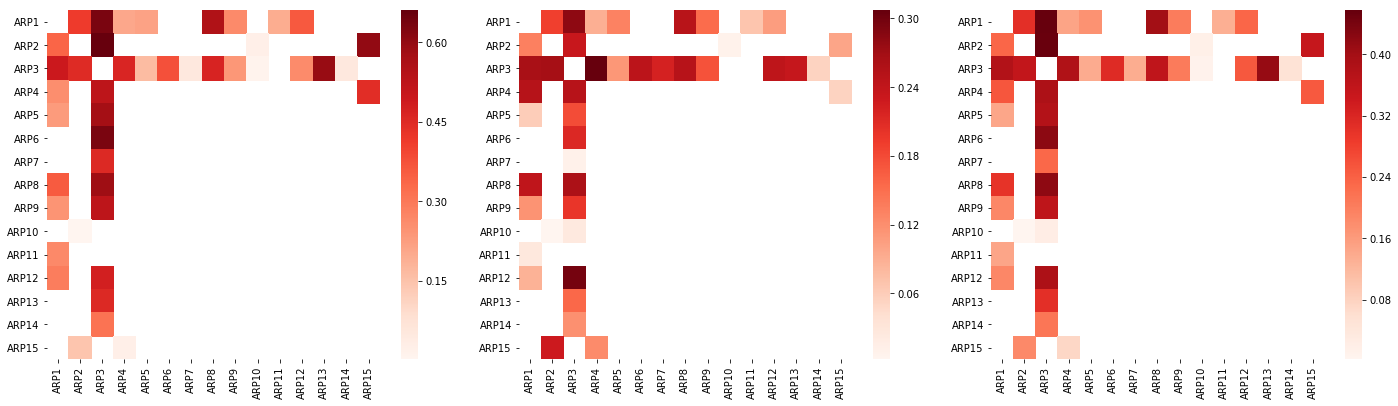

In [13]:
# 히트맵그래프
AFSNT_d1 =AFSNT[AFSNT['AOD'] == 'D']
AFSNT_a1 = AFSNT[AFSNT['AOD'] == 'A']

d1 = AFSNT_d1.loc[:, ['ARP','ODP','INT','DLY_RATE']]
a1 = AFSNT_a1.loc[:, ['ARP','ODP','INT','DLY_RATE']]
afsnt=AFSNT.loc[:, ['ARP','ODP','INT','DLY_RATE']]



a=['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15']

d1['ARP'] = d1['ARP'].astype('category', categories=a, ordered=True)
d1['ODP'] = d1['ODP'].astype('category', categories=a, ordered=True)


a1['ARP'] = a1['ARP'].astype('category', categories=a, ordered=True)
a1['ODP'] = a1['ODP'].astype('category', categories=a, ordered=True)

afsnt['ARP'] = afsnt['ARP'].astype('category', categories=a, ordered=True)
afsnt['ODP'] = afsnt['ODP'].astype('category', categories=a, ordered=True)

heatmap2_data1 = pd.pivot_table(d1,values='DLY_RATE', index=['ODP'], columns='ARP')
heatmap2_data2 = pd.pivot_table(a1,values='DLY_RATE', index=['ODP'], columns='ARP')
heatmap2_data3 = pd.pivot_table(afsnt,values='DLY_RATE', index=['ODP'], columns='ARP')


fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
sns.heatmap(heatmap2_data1, cmap="Reds",ax=ax1); ax1.set_xlabel(""); ax1.set_ylabel("");
sns.heatmap(heatmap2_data2, cmap="Reds",ax=ax2); ax2.set_xlabel(""); ax2.set_ylabel("");
sns.heatmap(heatmap2_data3, cmap="Reds",ax=ax3); ax3.set_xlabel(""); ax3.set_ylabel("");


plt.tight_layout(pad = 2)
plt.show()


##계획시간에 따른 지연확률

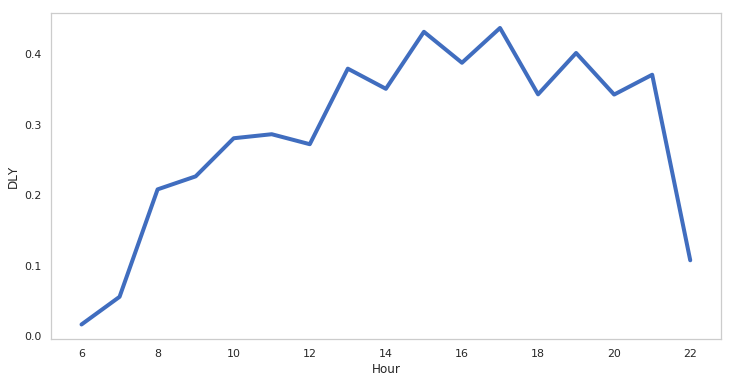

In [14]:
# 계획시각에 따른 지연 확률
sns.set(rc={'figure.figsize':(12,6), "lines.linewidth" : 4}, style="whitegrid")
sns.lineplot(x = 'Hour', y = 'DLY', data = AFSNT, ci = None,color='#406dbf')
plt.ylabel("DLY")
plt.grid(False)

In [15]:
AFSNT.head(3)

,Year,Month,Day,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE,Date,flights,STT_minute,STT_category,slots,Hour,Weekday
0,2019,9,16,¿ù,ARP1,ARP3,A,A1901,D,6:05,0.0,0.0635,2019-09-16,332,365.0,7,9,6,0
1,2019,9,16,¿ù,ARP1,ARP3,I,I1301,D,6:05,0.0,0.1877,2019-09-16,332,365.0,7,9,6,0
2,2019,9,16,¿ù,ARP1,ARP3,F,F1201,D,6:10,0.0,0.1113,2019-09-16,332,370.0,7,9,6,0


##요일별 지연확률/지연항공편수

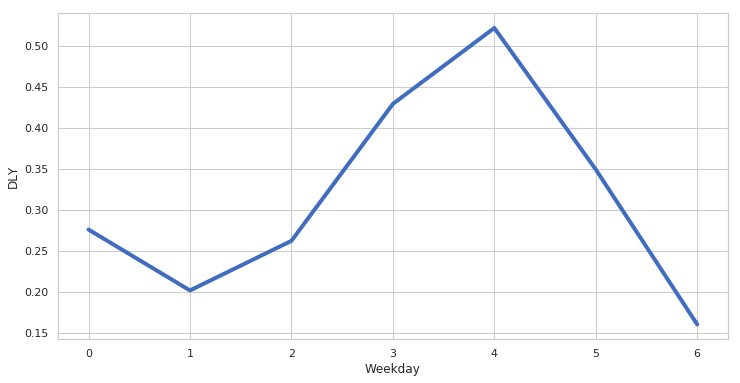

In [16]:
sns.lineplot(x = 'Weekday', y = 'DLY', data = AFSNT, ci = None,color='#406dbf')

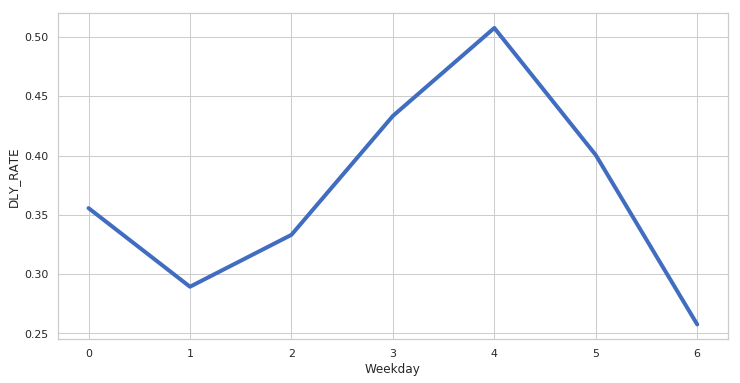

In [17]:
sns.lineplot(x = 'Weekday', y = 'DLY_RATE', data = AFSNT, ci = None,color='#406dbf')

In [18]:
AFSNT.head(3)

,Year,Month,Day,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE,Date,flights,STT_minute,STT_category,slots,Hour,Weekday
0,2019,9,16,¿ù,ARP1,ARP3,A,A1901,D,6:05,0.0,0.0635,2019-09-16,332,365.0,7,9,6,0
1,2019,9,16,¿ù,ARP1,ARP3,I,I1301,D,6:05,0.0,0.1877,2019-09-16,332,365.0,7,9,6,0
2,2019,9,16,¿ù,ARP1,ARP3,F,F1201,D,6:10,0.0,0.1113,2019-09-16,332,370.0,7,9,6,0


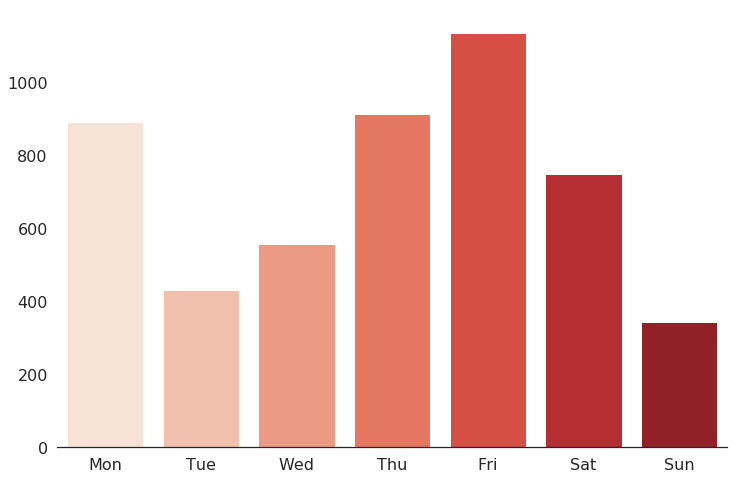

In [19]:
# 요일별 지연 항공편 수
df_dow = AFSNT.loc[:, ['Date', 'DLY']]
df_dow['DLY'] = df_dow['DLY'].replace("Y", 1).replace("N", 0)
df_dow['Date'] = pd.to_datetime(df_dow['Date'])
df_dow['DOW'] = df_dow['Date'].dt.strftime('%a')
grp_dow = df_dow.groupby('DOW', axis = 0).sum()
grp_dow.reset_index(inplace = True)
grp_dow.set_index('DOW', append = False, inplace = True)
grp_dow = grp_dow.transpose()
grp_dow = grp_dow[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].transpose()
grp_dow.reset_index(inplace = True)
grp_dow

fig = plt.figure(figsize = (12, 8))
sns.set_style("white")



#sub_color = sns.light_palette((180, 90, 60), input="husl", n_colors = 7, reverse = True)
ax = sns.barplot(x= 'DOW', y = 'DLY', data = grp_dow, palette="Reds")


#sub_color = sns.light_palette((180, 90, 60), input="husl", n_colors = 7, reverse = True)
#ax = sns.barplot(x= 'DOW', y = 'DLY', data = grp_dow, palette = sub_color)
plt.xlabel("")
plt.ylabel("")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
    
sns.despine(left=True)
plt.show()

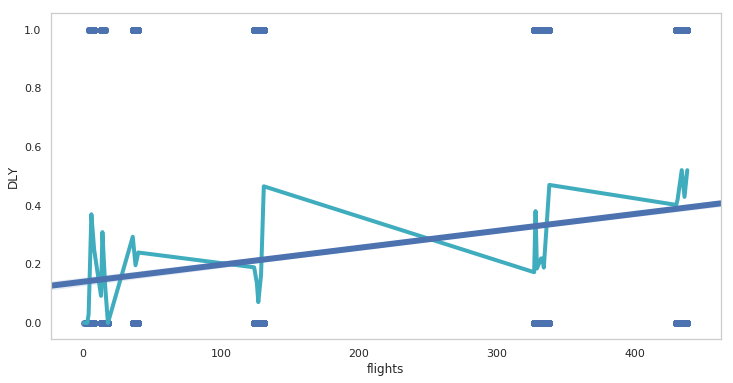

In [30]:
sns.set(rc={'figure.figsize':(12,6), "lines.linewidth" : 4}, style="whitegrid")
ax=sns.lineplot(x = 'flights', y = 'DLY', data = AFSNT, ci = None,color='#40adbf')
sns.regplot(x='flights', y='DLY', data=AFSNT, fit_reg=True);
plt.grid(False)

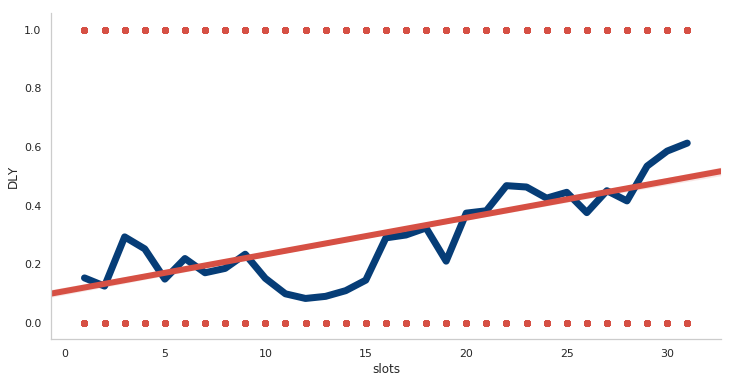

In [68]:

sns.set(rc={'figure.figsize':(12,6), "lines.linewidth" : 4}, style="whitegrid")
ax=sns.lineplot(x = 'slots', y = 'DLY', data = AFSNT, ci = None,color='#063d77',linewidth=7)
sns.regplot(x='slots', y='DLY', data=AFSNT, color='#d65044' ,fit_reg=True);
plt.grid(False)
sns.despine(left=False)

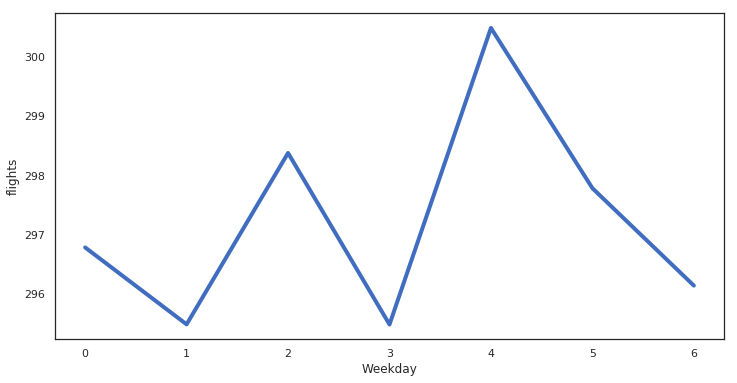

In [58]:
sns.lineplot(x = 'Weekday', y = 'flights', data = AFSNT, ci = None,color='#406dbf')

In [80]:
AFSNT.groupby('Weekday').count()['Year']

Weekday
0    3228
1    2132
2    2128
3    2124
4    2172
5    2144
6    2148
Name: Year, dtype: int64